In [2]:
from typing import Tuple, Dict, Hashable

import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt

colors = np.array(['tab:blue', 'orange'])

In [3]:
def compute_cut_score(G: nx.graph, S: nx.Graph):
    """
    Returns the cut score for the subgraph S of the Graph G.

    \phi(S) = w(E(S, \bar{S})) / min(vol(S), vol(\bar{S}))
    """
    
    #Taking min of vol(S),vol(\bar{S})
    Vol_G = nx.volume(G, G.nodes())
    Vol_S = nx.volume(S, S.nodes())
    
    if Vol_G == Vol_S:
        #No cut happened, return np.inf to not mess with min
        return np.inf
    
    if Vol_S >= Vol_G/2:
        vol = Vol_G - Vol_S
    else:
        vol = Vol_S
        
    #Getting the weights of edges on the boundary of S and summing them
    bound_edges = nx.edge_boundary(G, S.nodes())
    bound_weights = sum(list([G[edge[0]][edge[1]]["weight"] for edge in bound_edges]))
    
    if bound_weights == 0:
        #Cutting nothing...
        return np.inf
    
    res = bound_weights / vol
    return res
    

In [4]:
def sweep_cut(G: nx.Graph, x: np.ndarray) -> (float, float, np.ndarray):
    """Sweep Cut
    
    Also known as threshold cut, takes in a graph and a
    1D embedding of the nodes and returns a threshold,
    the conductance from the associated threshold cut and
    a 0/1 vector indicating which side of the cut each node
    belongs to in the best conductance cut.
    
    Parameters
    ----------
    G : nx.Graph
        The graph to compute the threshold cut for.
    x : np.ndarray
        1D Embedding of the nodes in G.
        
    Returns
    -------
    thr : float
        The best conductance threshold.
    conductance : float
        Conductance \phi(S) = w(E(S, \bar{S})) / min(vol(S), vol(\bar{S}))
        of the best threshold cut
    cut : np.ndarray
        0/1 indicator vector of the best threshold cut.
        It holds that cut = (x <= thr)
    """
    n = len(G)
        
    if len(x.shape) != 1:
        raise ValueError(f'Embedding should be one dimensional. Instead got `x` with shape {x.shape}.')
        
    
    #Array of cut scores
    cut_arr = np.zeros(len(x) - 1)
    cut_arr[:] = np.nan
    
    
    #Sort v_2, want the argument list. Don't care about stability, just speed
    x_arg = np.argsort(x, kind='heapsort')

    #Introduce subgraph S
    S = nx.Graph()
    
    #Incrementally add to S, using the nodes of the indices in x_arg
    for i in range(len(x_arg) - 1):
        S.add_node(x_arg[i])
        S.add_edges_from(G.edges(x_arg[i]))

        #Compute cut score for S
        cut_arr[i] = compute_cut_score(G, S)
        
    #The threshold is the minimum cut score
    thr = np.argmin(cut_arr)
    
    #The cut separates the two 
    cut = np.array([1 if i <= thr else 0 for i in range(len(x))])
    
    conductance = cut_arr[thr]
        
    return thr, conductance, cut




On the path with 20 nodes the best conductance threshold is thr = 8.000000 and yields conductance 0.055556.


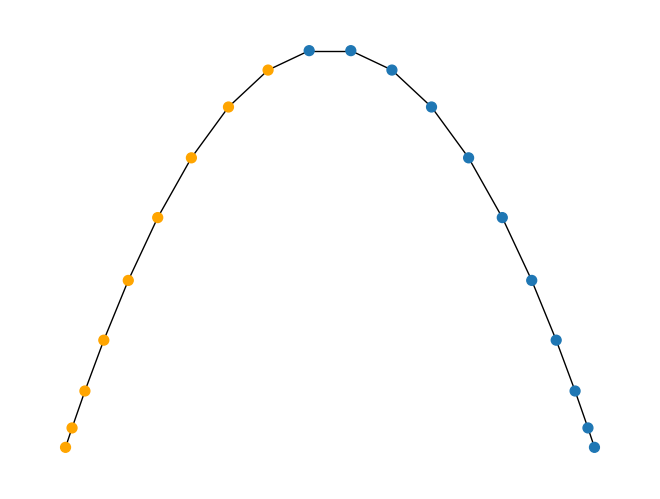

In [5]:
n = 20
P = nx.path_graph(n)
nx.set_edge_attributes(P, 1, 'weight')
x = np.linspace(0, 1, n)
thr, cond, cut = sweep_cut(P, x)

print(f'On the path with {n} nodes the best conductance threshold is thr = {thr:.6f} and yields conductance {cond:.6f}.')
pos = nx.spectral_layout(P)
nx.draw(P, pos=pos, node_color=colors[cut], node_size=50)

## Part 2??

In [9]:
import scipy.sparse
from scipy.sparse.linalg import eigsh

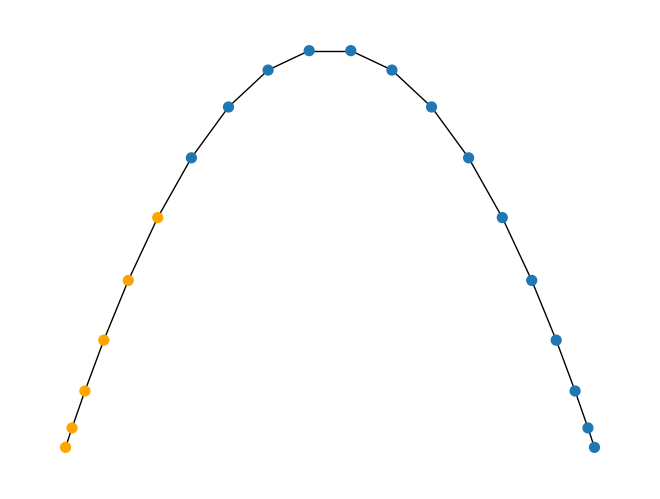

In [10]:
def spectral_clustering(G: nx.Graph, k: int=2) -> (np.ndarray, np.ndarray):
    """Spectral Clustering
    
    Taking a graph `G` and an integer `k`,
    Compute the k-th eigenvector.
    Decide on the best threshold cut.
    Return a vector of its nodes with values
    in {0, 1} indicating which side of the cut each node belongs to.
    
    Parameters
    ----------
    G : nx.Graph
        Graph to do spectral clustering on.
    k : int
        Which eigenvectors to use for clustering.
        
    Returns
    -------
    v : np.ndarray
        The first k+1 eigenvectors.
    cut : np.ndarray
        0/1 indicator vectors of the best threshold cut on the {1, ..., k+1} eigenvectors. 
    """
    n = len(G)
    if not (1 <= k <= n):
        raise ValueError(f'The choice of `k` must be between 1 and n. Instead {k} was passed.')
    
    v = np.zeros((n, k+1))
    cut = [np.zeros(n, int) for _ in range(k)]
    
    #Getting Laplcaian Matrix
    Lap = nx.laplacian_matrix(G)
    
    #Getting eigenvectors
    _ , evect = eigsh(Lap.astype(float), k=k+1, which='SM')
    
    for i, eigenvector in enumerate(evect.T):
        _, _, e_cut = sweep_cut(G, eigenvector)
        v[:, i] = eigenvector 
        cut.append(e_cut)
    return v, cut

_, cut = spectral_clustering(P, 7)
nx.draw(P, pos=pos, node_color=colors[cut[-2]], node_size=50)

# Part 3???

In [18]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph

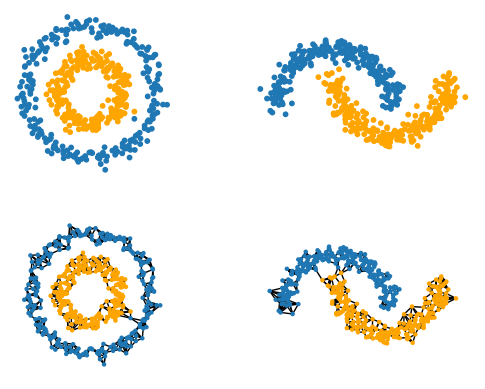

In [84]:

 

def generate_datasets(k=5, noise_multiplier=1):
    # ============
    # Generate datasets. We choose the size big enough to see the scalability
    # of the algorithms, but not too big to avoid too long running times
    # ============

    n_samples = 500
    seed = 17
    noisy_circles = datasets.make_circles(
        n_samples=n_samples, factor=0.5, noise=0.07 * noise_multiplier, random_state=seed
    )
    noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.10 * noise_multiplier, random_state=seed)
    data = []

    for i, (X, y) in enumerate([noisy_circles, noisy_moons]):
        G = nx.empty_graph(n_samples)
        
        #Take k-nearest neighbors
        neighbor_csr = kneighbors_graph(X, k)
        
        
        G = nx.from_scipy_sparse_array(neighbor_csr)
        
        A = np.zeros((len(G), len(G)))
        
        for i in range(len(G)):
            for j in range(i, len(G)):
                if i == j: pass
                if G.has_edge(i, j) and G.has_edge(j, i):
                    A[i, j] = 2.0
                    A[j, i] = 2.0
                elif G.has_edge(i, j):
                    A[i, j] = 1.0
                    A[j, i] = 1.0
                elif G.has_edge(j, i):
                    A[i, j] = 1.0
                    A[j, i] = 1.0
                    
        
        G = nx.from_numpy_array(A)
        # TODO: Use `kneighbors_graph` with n_neighbors equal to 5 to construct a graph
        #       a graph from each dataset.
        #       One way to make it into an undirected graph is to take A_u = (A_d + A_d^T) / 2
        #       This will give you the adjacency matrix.
        #       You can make it into a graph using `nx.from_scipy_sparse_matrix

        data.append([X, y, G])

    return data

data = generate_datasets()
fig, ax = plt.subplots(2, 2)

for i, (X, y, G) in enumerate(data):
    ax[0][i].scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
    plt.sca(ax[1][i])
    nx.draw(G, pos=X, node_color=colors[y], node_size=5)
    
    for j in range(2):
        ax[j][i].set_aspect('equal', 'box')
        ax[j][i].set_xticks([])
        ax[j][i].set_yticks([])
        for side in ['right', 'top', 'left', 'bottom']:
            ax[j][i].spines[side].set_visible(False)

In [90]:
_, _, G = data[0]
for edge in G.edges().values():
    print(edge['weight'])

2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
